In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
df = pd.read_csv("./train.txt", sep="\t", names=['labels','reviews'])
df

,labels,reviews
0,TRUTHFULPOSITIVE,The sheraton was a wonderful hotel! When me an...
1,TRUTHFULPOSITIVE,We stayed at the Omni between Christmas and Ne...
2,DECEPTIVENEGATIVE,I was REALLY looking forward to a nice relaxin...
3,TRUTHFULNEGATIVE,"First let me say, I try not to be too critical..."
4,DECEPTIVENEGATIVE,The Ambassador East Hotel is a terrible place ...
...,...,...
1395,TRUTHFULNEGATIVE,I stayed here for 5 nights last summer. I book...
1396,TRUTHFULPOSITIVE,Stayed here for 3 nights for a Bridgestone/Fir...
1397,TRUTHFULNEGATIVE,I am staying here now and actually am compelle...
1398,TRUTHFULNEGATIVE,We stayed at this hotel with our two teenage d...


In [ ]:
df["res"] = df['labels'].apply(lambda x: 0 if x == 'TRUTHFULNEGATIVE'
                               else (1 if x == 'DECEPTIVEPOSITIVE'
                                     else (2 if x == 'TRUTHFULPOSITIVE' else 3)))
df.head()

,labels,reviews,res
0,TRUTHFULPOSITIVE,The sheraton was a wonderful hotel! When me an...,2
1,TRUTHFULPOSITIVE,We stayed at the Omni between Christmas and Ne...,2
2,DECEPTIVENEGATIVE,I was REALLY looking forward to a nice relaxin...,3
3,TRUTHFULNEGATIVE,"First let me say, I try not to be too critical...",0
4,DECEPTIVENEGATIVE,The Ambassador East Hotel is a terrible place ...,3


In [ ]:
train, valid, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
len(train), len(valid), len(test)
train

,labels,reviews,res
693,DECEPTIVEPOSITIVE,The InterContinental Chicago is located in the...,1
773,TRUTHFULNEGATIVE,I arrived and my friends were already there an...,0
164,TRUTHFULNEGATIVE,We stayed here because of the enthusiastic pos...,0
545,DECEPTIVENEGATIVE,After arriving at the Sofitel Chicago Water To...,3
51,TRUTHFULNEGATIVE,"This place is a dump. I booked on Priceline, b...",0
...,...,...,...
737,DECEPTIVENEGATIVE,I recently stayed at the Hotel Allegro Chicago...,3
426,DECEPTIVENEGATIVE,Although the Millennium Knickerbocker Hotel Ch...,3
270,TRUTHFULPOSITIVE,We stayed in the IC chicago for 6 nights from ...,2
892,DECEPTIVEPOSITIVE,If you are traveling anywhere near Lake Michi...,1


In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('res')
  #df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  df = df["reviews"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE) #batch_size
  return ds
  #copied from tensoflow tutorials with some changes

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(valid)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0]

In [ ]:
#Embedding + Model
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
#embedding = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(32, 50), dtype=float32, numpy=
array([[ 3.159817 ,  2.026229 , -2.9123042, ..., -1.9512153, -2.2274573,
        -2.498039 ],
       [ 2.4966733,  2.164528 , -2.3753307, ..., -2.0088048, -1.8493769,
        -1.3835179],
       [ 3.1820426,  1.8086444, -3.0571566, ..., -1.9111037, -2.201291 ,
        -2.062235 ],
       ...,
       [ 3.4877598,  2.6391325, -3.5743778, ..., -2.4655924, -2.479586 ,
        -2.0925837],
       [ 1.8119849,  1.0664191, -1.806253 , ..., -1.2543014, -1.4866112,
        -1.4905739],
       [ 2.8862152,  1.9242651, -2.5562782, ..., -1.5551786, -2.4501092,
        -2.356979 ]], dtype=float32)>

In [ ]:
len(list(train_data))

35

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer) #model.add(tf.keras.layers.Embedding(1000, 64, input_length=10))
model.add(tf.keras.layers.Dense(16, activation='relu'))
#model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='linear'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)
#if val_accuracy starts increasing and then starts to stabilyse and decrease a little bit, it means it is overfitting


Epoch 1/5
35/35 [==============================] - 53s 1s/step - loss: 1.2875 - accuracy: 0.3616 - val_loss: 1.2133 - val_accuracy: 0.4857
Epoch 2/5
35/35 [==============================] - 53s 2s/step - loss: 1.1084 - accuracy: 0.5491 - val_loss: 1.0675 - val_accuracy: 0.5357
Epoch 3/5
35/35 [==============================] - 49s 1s/step - loss: 0.9043 - accuracy: 0.6652 - val_loss: 0.9242 - val_accuracy: 0.6071
Epoch 4/5
35/35 [==============================] - 50s 1s/step - loss: 0.7010 - accuracy: 0.8250 - val_loss: 0.8155 - val_accuracy: 0.6000
Epoch 5/5
35/35 [==============================] - 51s 1s/step - loss: 0.5695 - accuracy: 0.8527 - val_loss: 0.7628 - val_accuracy: 0.6857


In [ ]:
teste_prediction = tfds.as_numpy(test_data)
print(type(teste_prediction))

<class 'tensorflow_datasets.core.dataset_utils._IterableDataset'>


In [ ]:
predictions_logits = model.predict(teste_prediction)
predictions = tf.nn.softmax(predictions_logits)
print(predictions_logits.shape)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
for i in range(len(predicted_labels)):
    print(f"Predicted Label: {predicted_labels[i]}, Actual: {list(test_data)[0][1][0]}")

IndexError: ignored

In [ ]:
predictions = model.predict(test_data)


predicted_labels = np.argmax(predictions, axis=1)

for i in range(len(predicted_labels)):
    print(f"Predicted Label: {predicted_labels[i]}")

5/5 [==============================] - 1s 215ms/step
Predicted Label: 0
Predicted Label: 2
Predicted Label: 2
Predicted Label: 1
Predicted Label: 1
Predicted Label: 0
Predicted Label: 2
Predicted Label: 2
Predicted Label: 1
Predicted Label: 0
Predicted Label: 3
Predicted Label: 2
Predicted Label: 3
Predicted Label: 0
Predicted Label: 1
Predicted Label: 2
Predicted Label: 0
Predicted Label: 1
Predicted Label: 0
Predicted Label: 0
Predicted Label: 3
Predicted Label: 1
Predicted Label: 1
Predicted Label: 0
Predicted Label: 2
Predicted Label: 1
Predicted Label: 0
Predicted Label: 3
Predicted Label: 3
Predicted Label: 2
Predicted Label: 1
Predicted Label: 3
Predicted Label: 0
Predicted Label: 3
Predicted Label: 2
Predicted Label: 1
Predicted Label: 0
Predicted Label: 1
Predicted Label: 3
Predicted Label: 2
Predicted Label: 0
Predicted Label: 0
Predicted Label: 2
Predicted Label: 0
Predicted Label: 1
Predicted Label: 3
Predicted Label: 0
Predicted Label: 0
Predicted Label: 1
Predicted Label:

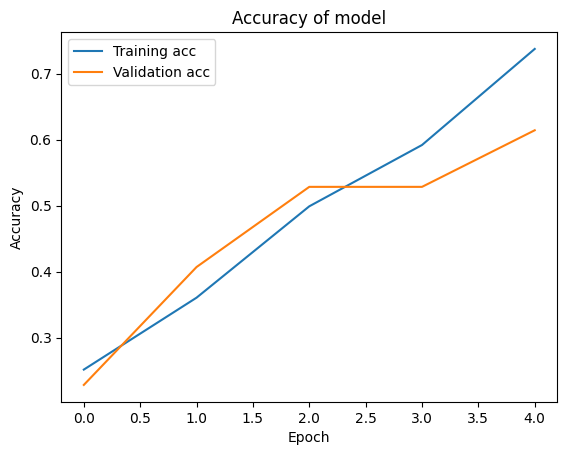

In [ ]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

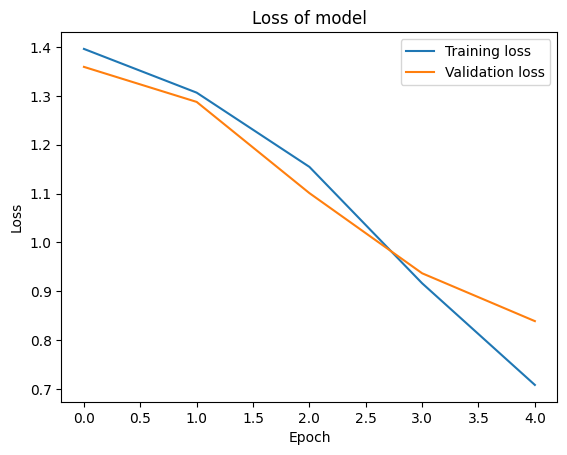

In [ ]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

#RNN (LSTM)

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab

array(['', '[UNK]', 'the', ..., 'yoga', 'wrote', 'wonderfully'],
      dtype='<U16')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


5/5 [==============================] - 0s 55ms/step - loss: 0.0000e+00 - accuracy: 0.2714


[0.0, 0.27142858505249023]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
35/35 [==============================] - 16s 285ms/step - loss: 0.0000e+00 - accuracy: 0.2438 - val_loss: 0.0000e+00 - val_accuracy: 0.2714
Epoch 2/5
35/35 [==============================] - 10s 293ms/step - loss: 0.0000e+00 - accuracy: 0.2438 - val_loss: 0.0000e+00 - val_accuracy: 0.2714
Epoch 3/5
35/35 [==============================] - 10s 278ms/step - loss: 0.0000e+00 - accuracy: 0.2438 - val_loss: 0.0000e+00 - val_accuracy: 0.2714
Epoch 4/5
35/35 [==============================] - 10s 276ms/step - loss: 0.0000e+00 - accuracy: 0.2438 - val_loss: 0.0000e+00 - val_accuracy: 0.2714
Epoch 5/5
35/35 [==============================] - 10s 287ms/step - loss: 0.0000e+00 - accuracy: 0.2438 - val_loss: 0.0000e+00 - val_accuracy: 0.2714


In [ ]:
model.evaluate(test_data)

5/5 [==============================] - 0s 47ms/step - loss: -24.9345 - accuracy: 0.2500


[-24.9344539642334, 0.25]